**Language Classifier: Is it Japanese or Chinese Mandarin**

Import Packages

In [1]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('languages.csv', encoding='utf-8')
df.head()

,mandarin,japanese
0,嗨。,行け。
1,你好。,行きなさい。
2,你用跑的。,こんにちは。
3,等等！,やっほー。
4,你好。,こんにちは！


Data Cleaning:

- Check to see if there are any NaN values
- Restructure DataFrame columns so it's easier to work with
- Shuffle and reset index

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
mandarin    1999 non-null object
japanese    1999 non-null object
dtypes: object(2)
memory usage: 31.4+ KB


In [4]:
df.isnull().sum()

mandarin    0
japanese    0
dtype: int64

In [5]:
df2 = df.drop(['japanese'],axis=1)
df2.columns = ['text']
df2['label'] = 'mandarin'

df3 = df.drop(['mandarin'],axis=1)
df3.columns = ['text']
df3['label'] = 'japanese'

df = pd.concat([df2, df3])

In [6]:
df = df.reset_index(drop=True)
df = shuffle(df)

Prepare Tokenizer(s):

Sentence Piece is an unsupervised tokenizer which you can train on raw data and use to tokenize/detokenize your dataset. You can learn more here: https://github.com/google/sentencepiece

In [7]:
# Train Japanese Tokenizer on Japanese Sentence Data

import sentencepiece as spm

spm.SentencePieceTrainer.train('--input=jpn_tokenizer.txt --model_prefix=m_jp --vocab_size=10000 --character_coverage=0.995 --model_type=bpe')
jp = spm.SentencePieceProcessor()
jp.load('m_jp.model')

True

In [8]:
# Train Chinese Tokenizer on Chinese Sentence Data

spm.SentencePieceTrainer.train('--input=cmn_tokenizer.txt --model_prefix=m_ch --vocab_size=10000 --character_coverage=0.995 --model_type=bpe')
ch = spm.SentencePieceProcessor()
ch.load('m_ch.model')

True

Prepare Japanese and Mandarin Stopwords:

In [9]:
cmn_stopwords = open("stopwords-zh.txt", "r", encoding='utf-8')
cmn_stop = [line.rstrip('\n') for line in cmn_stopwords]
jpn_stopwords = open("stopwords-ja.txt", "r", encoding='utf-8')
jpn_stop = [line.rstrip('\n') for line in jpn_stopwords]

Remove punctuation and digits

In [10]:
def punct_digit(text):
    pattern = '[0-9]'
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(pattern,'', text)
    return text

df['text'] = df['text'].apply(punct_digit)

In [11]:
df.head()

,text,label
2020,飛び跳ねて,japanese
782,下午好,mandarin
2182,私は太っている,japanese
2442,おやすみなさい,japanese
636,我会打电话给你,mandarin


Tokenization Stage:

- Tokenize Japanese text
- Remove Japanese Stopwords from text
- Replace Sentence Piece's Underscore with Spacing

Apply to only Japanese Text Rows

In [12]:
def jpn_clean(text):
    text = jp.encode_as_pieces(text)
    text = [t for t in text if not t in jpn_stop]
    text = ' '.join(text).replace('▁', ' ')
    return text

df['text'] = np.where(df['label'] == 'japanese', df['text'].apply(jpn_clean), df['text'])


- Tokenize Mandarin text
- Remove Mandarin Stopwords from text
- Replace Sentence Piece's Underscore with Spacing

Apply to only Mandarin Text Rows

In [13]:
def cmn_clean(text):
    text = str(text)
    text = ch.encode_as_pieces(text)
    text = [t for t in text if not t in cmn_stop]
    text = ' '.join(text).replace('▁', ' ')
    return text

df['text'] = np.where(df['label'] == 'mandarin', df['text'].apply(cmn_clean), df['text'])

In [14]:
df.head()

,text,label
2020,飛び 跳 ね,japanese
782,下午,mandarin
2182,私は 太っている,japanese
2442,お やす みなさい,japanese
636,我会 打电话 给你,mandarin


In [15]:
maxlen = 100                                                                     
max_words = 10000
max_features = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(df['label'])

enc = OneHotEncoder()
labels = labels.reshape(-1,1)
labels = enc.fit_transform(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)



Shape of data tensor: (3998, 100)
Shape of label tensor: (3998, 2)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

In [17]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=6,
                    batch_size=100,
                    validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2558 samples, validate on 640 samples
Epoch 1/6
2558/2558 [==============================] - 23s 9ms/step - loss: 0.6870 - acc: 0.5393 - val_loss: 0.6716 - val_acc: 0.5195
Epoch 2/6
2558/2558 [==============================] - 13s 5ms/step - loss: 0.5754 - acc: 0.7944 - val_loss: 0.4207 - val_acc: 0.9305
Epoch 3/6
2558/2558 [==============================] - 11s 4ms/step - loss: 0.2381 - acc: 0.9660 - val_loss: 0.1652 - val_acc: 0.9500
Epoch 4/6
2558/2558 [==============================] - 9s 3ms/step - loss: 0.0523 - acc: 0.9924 - val_loss: 0.1093 - val_acc: 0.9555
Epoch 5/6
2558/2558 [==============================] - 9s 4ms/step - loss: 0.0173 - acc: 0.9961 - val_loss: 0.0975 - val_acc: 0.9609
Epoch 6/6
2558/2558 [=============================

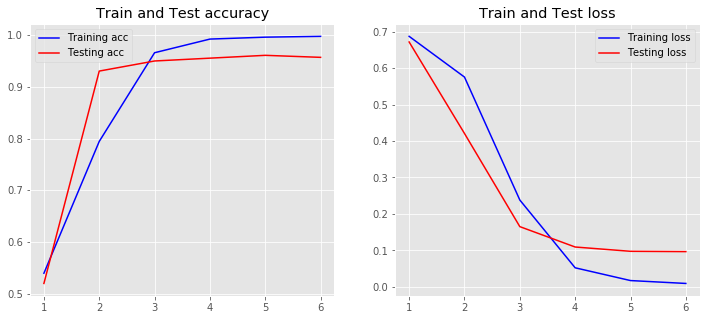

In [18]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Testing acc')
    plt.title('Train and Test accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Testing loss')
    plt.title('Train and Test loss')
    plt.legend()

plot_history(history)